In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd

/content


In [3]:
!ls "drive/MyDrive/COSC 606 Machine learning/Homework 2/Notebooks/"

'Task 1 OR gate with Softmax activation and Crossentropy loss.ipynb'
'Task 1 XOR gate with Sigmoid Activation and Squared Error Loss.ipynb'
'Task 1 XOR gate with Softmax activation and Crossentropy loss.ipynb'
'Task 2 work on MNIST data V1.ipynb'
'Task 3.1 Work on MNIST data V2.ipynb'
'Task 3.2 Work on MNIST data V3.ipynb'


In [ ]:
import os
os.chdir('drive/MyDrive/COSC 606 Machine learning/Homework 2/Notebooks/')
!pwd

/content/drive/MyDrive/COSC 606 Machine learning/Homework 2/Notebooks


In [ ]:
import numpy as np  # import numpy library

In [ ]:
!pip install idx2numpy

In [ ]:
def read_data(file_path):
    """
    Returns the numpy array of images, and labels  
    """
    # Dataset preparation
    import idx2numpy
    import numpy as np
    return idx2numpy.convert_from_file(file_path)

In [ ]:
!ls ../Dataset/

t10k-images-idx3-ubyte	train-images-idx3-ubyte
t10k-labels-idx1-ubyte	train-labels-idx1-ubyte


In [ ]:
train_image_path = "../Dataset/train-images-idx3-ubyte"
train_labels_path = "../Dataset/train-labels-idx1-ubyte"
test_image_path = "../Dataset/t10k-images-idx3-ubyte"
test_labels_path = "../Dataset/t10k-labels-idx1-ubyte"

# train data and labels
train_images = read_data(train_image_path)
train_labels = read_data(train_labels_path)

# test data and labels
test_images = read_data(test_image_path)
test_labels = read_data(test_labels_path)

In [ ]:
print("Train data info")
print(train_images.shape)
print(train_labels.shape)
print("\n")

print("Test data info")
print(test_images.shape)
print(test_labels.shape)

Train data info
(60000, 28, 28)
(60000,)


Test data info
(10000, 28, 28)
(10000,)


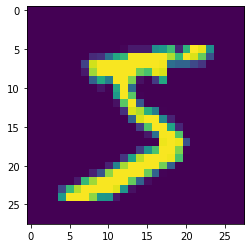

5


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_images[0], interpolation='nearest')
plt.show()
print(train_labels[0])

In [ ]:
type(train_images)

numpy.ndarray

In [ ]:
# Function which flattens the given image
def flatten(data):
    return data.reshape(data.shape[0], data.shape[1]*data.shape[2])

In [ ]:
X_train = flatten(train_images)
X_test = flatten(test_images)

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [ ]:
# Transpoing the training and testing data, because each column
# represents a single input
X_train = X_train.T
X_test = X_test.T
print(X_train.shape)
print(X_test.shape)

(784, 60000)
(784, 10000)


In [ ]:
X_train.shape

(784, 60000)

In [ ]:
# Scaling the pixel values from 0 to 1
X_train = X_train/255
X_test = X_test/255

In [ ]:
print(X_train.dtype)
print(X_test.dtype)

float64
float64


In [ ]:
# Now going to deal with 10 labels of the data
print(np.unique(train_labels))
print(np.unique(test_labels))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [ ]:
# Converting target to one hot encoding
# One hot encoding 
def one_hot_encoder(data):
    """ One hot encoding function
    Input  : categorical data 
    Output : One hot encoded of given input array
  
    Uses the lowest label byte encoding to make data efficient for training. 
    "int8" which covers from --> Byte (-128 to 127) is sufficient to cover the 
    required labels of 0 and 1 only for one hot encoded result.
    """
    encoded_data = np.zeros((data.shape[0], len(np.unique(data))), dtype='int8') 

    for i,j in enumerate(data):
        encoded_data[i][j] = 1
    
    return encoded_data
Y_train = one_hot_encoder(train_labels)
Y_test = one_hot_encoder(test_labels)
print(Y_train[0])
print(train_labels[0])

[0 0 0 0 0 1 0 0 0 0]
5


In [ ]:
Y_train = Y_train.T
Y_test = Y_test.T
print(Y_train.shape)
print(Y_test.shape)

(10, 60000)
(10, 10000)


In [ ]:
# Dividing training data into training and validation data
validation_percent = 0.1
validation_mask = int(validation_percent*X_train.shape[1])
X_val = X_train[:, -validation_mask:]
Y_val = Y_train[:, -validation_mask:]

X_train = X_train[:, :-validation_mask]
Y_train = Y_train[:, :-validation_mask]

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(784, 54000)
(10, 54000)
(784, 6000)
(10, 6000)


### Dealing with dataset is complete
______
### Now working on the different layers of the neural network

In [ ]:
def initialize_parameters(n_in, n_out, ini_type='plain'):
    """
    Function to initialize some form of random weights and Zero biases
    Args:
        n_in: size of input layer
        n_out: size of output/number of neurons
        ini_type: set initialization type for weights
    Returns:
        params: a dictionary containing W and b
    """

    params = dict()  # initialize empty dictionary of neural net parameters W and b

    if ini_type == 'plain':
        params['W'] = np.random.randn(n_out, n_in) *0.01  # set weights 'W' to small random gaussian
    elif ini_type == 'xavier':
        params['W'] = np.random.randn(n_out, n_in) / (np.sqrt(n_in))  # set variance of W to 1/n
    elif ini_type == 'he':
        # Good when ReLU used in hidden layers
        params['W'] = np.random.randn(n_out, n_in) * np.sqrt(2/n_in)  # set variance of W to 2/n

    params['b'] = np.zeros((n_out, 1))    # set bias 'b' to zeros

    return params

In [ ]:
## Working on Linear Layer
class LinearLayer:
  def __init__(self, input_shape, n_out, initialization_type='plain'):
    self.m = input_shape[1]
    self.params = initialize_parameters(input_shape[0], n_out, initialization_type)
    self.Z = np.zeros((self.params['W'].shape[0], n_out))

  def forward(self, A_prev):
    """
    A_prev is the data coming from the previous layer, either may be input
    or may be result of activation
    """
    self.A_prev = A_prev
    # performing forward computation W*X + b
    self.Z = np.dot(self.params["W"], A_prev) + self.params["b"]
  
  def backward(self, upstream_grad):
    """
    Computes the back propagation on the linear layer
    """
    # derivative of cost w.r.t. Weights
    self.dW = np.dot(upstream_grad, self.A_prev.T)

    # derivative of cost w.r.t. bias
    self.dB = np.sum(upstream_grad, axis=1, keepdims=True)

    # derivative of cost w.r.t A_prev
    self.dA_prev = np.dot(self.params['W'].T, upstream_grad)
  
  def update_params(self, learning_rate=0.1):
    self.params["W"] = self.params["W"] - learning_rate*self.dW
    self.params["b"] = self.params["b"] - learning_rate*self.dB
  
  def print_initialized(self):
    print("------------------------------------------------------")
    print("Number of training examples : {}".format(self.m))
    # print("Weights : {}".format(self.params["W"]))
    # print("Biases : {}".format(self.params["b"]))
    # print("Resultant matrix Z : {}".format(self.Z))
    print("Weights shape : {}".format(self.params["W"].shape))
    print("Biases : {}".format(self.params["b"].shape))
    print("Resultant matrix Z : {}".format(self.Z.shape))
    

In [ ]:
class ReluLayer:
    """
    This implements activation layers inline with a computational graph model
    Args:
        shape: shape of input to the layer
    Methods:
        forward(Z)
        backward(upstream_grad)
    """

    def __init__(self, shape):
        """
        The consturctor of the ReLU activation layer takes in the following arguments
        Args:
            shape: shape of input to the layer
        """
        self.A = np.zeros(shape)  # create space for the resultant activations

    def forward(self, Z):
        """
        This function performs the forwards propagation step through the activation function
        Args:
            Z: input from previous (linear) layer
        """
        self.A = Z
        self.A = np.maximum(self.A, 0)  # compute activations

    def backward(self, upstream_grad):
        """
        This function performs the  back propagation step through the activation function
        Local gradient => derivative of relu => 1 for +ve and 0 for -ve
        Args:
            upstream_grad: gradient coming into this layer from the layer above
        """
        # couple upstream gradient with local gradient, the result will be sent back to the Linear layer
        self.dZ = np.array(upstream_grad, copy=True) 
        self.dZ[self.A <= 0] = 0

    def print_values(self):
      # print("Activation values {}".format(self.A))
      print("Activation shape {}".format(self.A.shape))

In [ ]:
class SoftmaxLayer:
  """
  This class is used as a activation layer for final layer
  It has sigmoid activation, and its derivative for back-prop
  """
  def __init__(self, shape):
    self.A = np.zeros(shape)
  
  def forward(self, Z):
    self.A = np.exp(Z - np.max(Z, axis=0))  # shift values
    self.A = self.A / np.sum(self.A, axis=0)

  def print_activation(self):
    print("Activation {}".format(self.A))
    print("Activation shape {}".format(self.A.shape))

  def softmax_grad(self, individual_Activations, upstream):
    s = individual_Activations.reshape(-1,1)
    return np.dot(np.diagflat(s) - np.dot(s, s.T), upstream)

  def backward(self, upstream_grad):
    self.dZ = self.A.T
    for i in range(len(self.dZ)):
      self.dZ[i] = self.softmax_grad(self.dZ[i], upstream_grad.T[i])
    self.dZ = self.dZ.T

In [ ]:
def categorical_crossentropy(Y, Y_hat):
  """
  This function computes the categorical cross entropy cost, and its derivative
  The cost function is optimized for computing cost
  Actual categorical cross entropy loss = -sum(Y_i*log(Yhati))
  However, the computation has been optimized, since the Yi is only 1 at the 
  required target thus loss = -sum(log(Yhat_i_of_j))
  """
  m = Y.shape[1]
  # cost = np.sum([-np.log(j[np.argmax(Y_train, axis=0)[i]]) for i,j in enumerate(Y_hat.T)])/m
  mask = Y_hat*Y
  cost = np.sum(-np.log(mask[mask!=0]))/m # removing 0 elements from selection
  dY_hat = (Y_hat - Y)/m# derivative of the cost
  return cost, dY_hat

______
### With 3 hidden layers

In [ ]:
def accuracy(X, Y):
  # Accuracy function specific to 3 layered hidden network
  m = X.shape[1]
  
  # Forward passing
  Z1.forward(X)
  A1.forward(Z1.Z)
  
  Z2.forward(A1.A)
  A2.forward(Z2.Z)
  
  Z3.forward(A2.A)
  A3.forward(Z3.Z)
  
  Z4.forward(A3.A)
  A4.forward(Z4.Z)
  
  prediction = np.argmax(A4.A, axis=0)
  true_label = np.argmax(Y, axis=0)
  accuracy = np.sum(prediction==true_label)/m

  return accuracy*100


In [ ]:
np.random.seed(64) # set seed value so that the results are reproduceable

# Our network architecture has the shape: 
# (input)--> [Linear->Sigmoid] -> [Linear->Sigmoid] -> [Linear->Sigmoid] ->(output)  

batch_size = 128 # for batch

#------ LAYER-1 ----- define hidden layer that takes in training data 
Z1 = LinearLayer(input_shape=(X_train.shape[0], batch_size), n_out=64, initialization_type='he')
A1 = ReluLayer(Z1.Z.shape)

#------ LAYER-2 ----- define hidden layer that take in data from first hidden layer
Z2 = LinearLayer(input_shape=A1.A.shape, n_out=32, initialization_type='he')
A2 = ReluLayer(Z2.Z.shape)

#------ LAYER-3 ----- define hidden layer that takes in values from second hidden layer
Z3 = LinearLayer(input_shape=A2.A.shape, n_out=32, initialization_type='he')
A3 = ReluLayer(Z3.Z.shape)

#------ LAYER-4 ----- define output layer that take is values from 3rd hidden layer
Z4 = LinearLayer(input_shape=A3.A.shape, n_out=10, initialization_type='he')
A4 = SoftmaxLayer(Z4.Z.shape)

In [ ]:
# define training constants
learning_rate = 1.0
number_of_epochs = 100

# batchsize
batch_size = 128
data_size = X_train.shape[1]
total_batch = int(np.round(data_size/batch_size))

costs = []
train_accuracies = []
validation_accuracies = []

for epoch in range(number_of_epochs):
  previous = 0
  current = previous + batch_size
  batch_cost = 0
  batch_accuracy = 0
  for i in range(total_batch):
    
    X_train_batch = X_train[:, previous:current]
    Y_train_batch = Y_train[:, previous:current]
    # ------------------------- forward-prop -------------------------
    Z1.forward(X_train_batch) # forward pass for first linear layer
    A1.forward(Z1.Z)          # forward pass for activation for first hidden layer
    
    Z2.forward(A1.A)          # forward pass for second linear layer
    A2.forward(Z2.Z)          # forward pass for activation for second hidden layer
    
    Z3.forward(A2.A)          # forward pass for third linear layer
    A3.forward(Z3.Z)          # forward pass for activation for third hidden layer

    Z4.forward(A3.A)          # forward pass for output linear layer
    A4.forward(Z4.Z)          # forward pass for activation for output layer
    
    # ---------------------- Compute Cost ----------------------------
    cost, dA4 = categorical_crossentropy(Y=Y_train_batch, Y_hat=A4.A)
    batch_cost += cost
    batch_accuracy += accuracy(X_train_batch, Y_train_batch)
    # ------------------------- back-prop ----------------------------
    A4.backward(dA4)
    Z4.backward(A4.dZ)
    
    A3.backward(Z4.dA_prev)
    Z3.backward(A3.dZ)
    
    A2.backward(Z3.dA_prev)
    Z2.backward(A2.dZ)
    
    A1.backward(Z2.dA_prev)
    Z1.backward(A1.dZ)
    
    # ----------------------- Update weights and bias ----------------
    Z4.update_params(learning_rate=learning_rate)
    Z3.update_params(learning_rate=learning_rate)
    Z2.update_params(learning_rate=learning_rate)
    Z1.update_params(learning_rate=learning_rate)
    
    
    previous = current
    current = previous+batch_size
  # print and store Costs and accuracy in every 5 iterations
  if (epoch % 5) == 0:
    train_acc = batch_accuracy/total_batch
    overall_cost = batch_cost/total_batch
    val_acc = accuracy(X_val, Y_val)
    print("epoch # {} \n Cost : {} \t Train Accuracy : {} \t Validation Accuracy : {}".format(str(epoch)[:5], str(str(cost)+str(00000))[:7], str(str(train_acc)+str(00000))[:7], str(str(val_acc)+str(00000))[:7]))
    costs.append(overall_cost)
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

epoch # 0 
 Cost : 0.31019 	 Train Accuracy : 84.8978 	 Validation Accuracy : 94.6666
epoch # 5 
 Cost : 0.16993 	 Train Accuracy : 97.4200 	 Validation Accuracy : 96.250
epoch # 10 
 Cost : 0.09652 	 Train Accuracy : 98.2166 	 Validation Accuracy : 97.10
epoch # 15 
 Cost : 0.14172 	 Train Accuracy : 98.6075 	 Validation Accuracy : 97.4833
epoch # 20 
 Cost : 0.09215 	 Train Accuracy : 98.9630 	 Validation Accuracy : 97.0666
epoch # 25 
 Cost : 0.13277 	 Train Accuracy : 99.1240 	 Validation Accuracy : 97.250
epoch # 30 
 Cost : 0.11436 	 Train Accuracy : 99.0740 	 Validation Accuracy : 97.5166
epoch # 35 
 Cost : 0.10632 	 Train Accuracy : 99.2147 	 Validation Accuracy : 97.7833
epoch # 40 
 Cost : 0.11940 	 Train Accuracy : 99.2425 	 Validation Accuracy : 97.60
epoch # 45 
 Cost : 0.10327 	 Train Accuracy : 99.2703 	 Validation Accuracy : 97.7333
epoch # 50 
 Cost : 0.09561 	 Train Accuracy : 99.3425 	 Validation Accuracy : 97.60
epoch # 55 
 Cost : 0.07235 	 Train Accuracy : 99.277

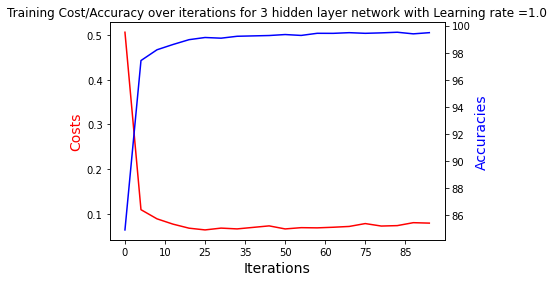

In [ ]:
def learning_curve(costs, accuracies, total_epochs):
  import matplotlib.pyplot as plt
  # create figure and axis objects with subplots()
  steps = int(total_epochs / len(accuracies))  # the steps at which costs and accuracy were recorded

  fig,ax = plt.subplots()
  # making a plot
  ax.plot(np.squeeze(costs), color="red")
  # set Iterations label
  ax.set_xlabel("Iterations",fontsize=14)
  # set y-axis label, first costs
  ax.set_ylabel("Costs",color="red",fontsize=14)

  # twin object for two different y-axis on the same plot
  ax2=ax.twinx()
  # make a plot with accuracies in y-axis using second axis object
  ax2.plot(np.squeeze(accuracies), color="blue")
  ax2.set_ylabel("Accuracies", color="blue", fontsize=14)

  locs, labels = plt.xticks()
  plt.xticks(locs[1:-1], tuple(np.array(locs[1: -1], dtype='int')*steps))  # change x labels of the plot
  plt.xticks()
  plt.title("Training Cost/Accuracy over iterations for 3 hidden layer network with Learning rate =" + str(learning_rate))
  plt.show()

learning_curve(costs, train_accuracies, number_of_epochs)

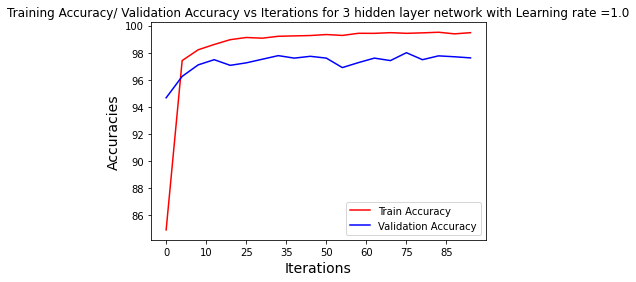

In [ ]:
def train_vs_validation_curve(train_accuracies, validation_accuracies, total_epochs):
  import matplotlib.pyplot as plt
  # create figure and axis objects with subplots()
  steps = int(total_epochs / len(train_accuracies))  # the steps at which costs and accuracy were recorded

  fig,ax = plt.subplots()
  # making a plot
  ax.plot(np.squeeze(train_accuracies), color="red", label='Train Accuracy')
  # set Iterations label
  ax.set_xlabel("Iterations",fontsize=14)
  # set y-axis label, first costs
  ax.set_ylabel("Accuracies", fontsize=14)

  ax.plot(np.squeeze(validation_accuracies), color="blue", label="Validation Accuracy")

  locs, labels = plt.xticks()
  plt.xticks(locs[1:-1], tuple(np.array(locs[1: -1], dtype='int')*steps))  # change x labels of the plot
  plt.xticks()
  plt.title("Training Accuracy/ Validation Accuracy vs Iterations for 3 hidden layer network with Learning rate =" + str(learning_rate))
  plt.legend()
  plt.show()

train_vs_validation_curve(train_accuracies, validation_accuracies, number_of_epochs)

In [ ]:
print("Training accuracy for 3 hidden layered network  : {}".format(accuracy(X_train, Y_train)))

Training accuracy for 3 hidden layered network  : 98.60925925925926


In [ ]:
print("Validation accuracy for 3 hidden layered network  : {}".format(accuracy(X_val, Y_val)))

Validation accuracy for 3 hidden layered network  : 97.15


In [ ]:
print("Test accuracy for 3 hidden layered network  : {}".format(accuracy(X_test, Y_test)))

Test accuracy for 3 hidden layered network  : 96.37
